# How to create the training dataset?

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up
import DeepINN as dp

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


### Geometry

In [2]:
# A simple 1D geometry
X = dp.spaces.R1('x')
Line = dp.domains.Interval(X, 0, 1)

In [3]:
import torch

In [4]:
left_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([0.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 0.0)
right_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([1.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 1.0)
interior_points = dp.constraint.PDE(geom = Line,
                                    sampling_strategy= "grid",
                                    no_points = 20)

In [5]:
# debugging
interior_points.sampler_object().sample_points().as_tensor.size(), left_bc.sampler_object().sample_points().as_tensor.size(), right_bc.sampler_object().sample_points().as_tensor.size()


/home/hell/Desktop/DeepINN/Tutorials/4. Dataset/../../DeepINN/geometry/samplers/grid_samplers.py:78: UserWarning: First iteration did not find any valid grid points, for
                             the given filter.
                             Will try again with n = 10 * self.n_points. Or
                             else use only random points!
  warnings.warn("""First iteration did not find any valid grid points, for


(torch.Size([20, 1]), torch.Size([1, 1]), torch.Size([1, 1]))

In [6]:
# debugging 
interior_points.sample_labels(interior_points.sampler_object().sample_points().as_tensor).unsqueeze(1).size()

torch.Size([20, 1])

In [7]:
temp = left_bc.sampler_object().sample_points().as_tensor.size()
temp

torch.Size([1, 1])

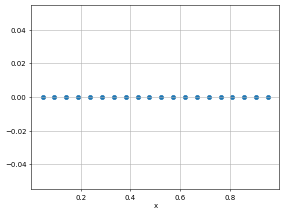

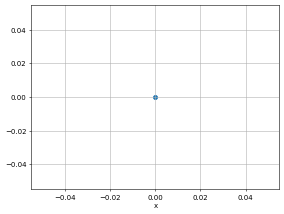

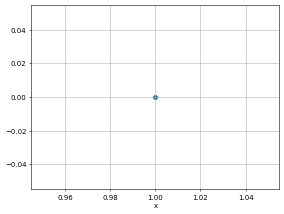

In [8]:
dp.utils.scatter(X, interior_points.sampler_object(), dpi = 50)
dp.utils.scatter(X, left_bc.sampler_object(), dpi = 50)
dp.utils.scatter(X, right_bc.sampler_object(), dpi = 50)

### 1D Laplace equation

In [9]:
def laplace(X,y):
    """
    1D Laplace equation.
    u__x = 0 
    """
    dy_x = dp.constraint.Jacobian(X, y)
    dy_xx = dp.constraint.Jacobian(X, y)(i = 0, j = 0)

    return dy_xx


### Dataset

In [10]:
dataset = dp.domain.Generic(laplace,
                            interior_points,
                            [left_bc, right_bc])

In [11]:
# Don't use this function. collocation_point_labels() returns both inputs and labels
collocation_point_sample = dataset.sample_collocation_points()
collocation_point_sample.size()

torch.Size([20, 1])

In [12]:
collocation_point_sample, collocation_point_labels = dataset.sample_collocation_labels()
collocation_point_sample.size(), collocation_point_labels.size()

(torch.Size([20, 1]), torch.Size([20, 1]))

In [13]:
# Don't use this sample_boundary_labels() returns both inputs and labels
boundary_point_sample = dataset.sample_boundary_points()
boundary_point_sample

[tensor([[0.]]), tensor([[1.]])]

In [14]:
boundary_point_sample, boundary_point_labels = dataset.sample_boundary_labels()
len(boundary_point_sample), len(boundary_point_labels)

(2, 2)

In [15]:
boundary_point_labels

[tensor([[0.]]), tensor([[1.]])]

In [16]:
boundary_point_labels[0].size()

torch.Size([1, 1])

In [17]:
boundary_point_sample[0].requires_grad = True

# y is the output neuron of a hypothetical neural network
# the output and the input should be connected to the graph to enable chain rule.
y = boundary_point_sample[0] + boundary_point_labels[0]

In [18]:
laplace(boundary_point_sample[0],y)

tensor([[1.]])